In [1]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
from keras.optimizers import RMSprop

In [2]:
data_path = 'deu.txt'

In [3]:
# Upload the data file
from google.colab import files
uploaded_files = files.upload()

# Process the uploaded file
for filename, content in uploaded_files.items():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(content)))

Saving deu.txt to deu.txt
User uploaded file "deu.txt" with length 41615081 bytes


In [4]:
# Define training parameters
batch_size = 64
epochs = 40
latent_dim = 256
num_samples = 30000

In [5]:
# Initialize lists for input and output texts
source_texts = []
target_texts = []

# Initialize sets for unique input and output characters
source_characters = set()
target_characters = set()

# Read data from the file and preprocess
with open(data_path, 'r', encoding='utf-8') as file:
    lines = file.read().split('\n')

for line in lines[:min(num_samples, len(lines) - 1)]:
    source_text, target_text, _ = line.split('\t')

    # Add start and end tokens to the target text
    target_text = '\t' + target_text + '\n'

    # Append texts to lists
    source_texts.append(source_text)
    target_texts.append(target_text)

    # Update sets of unique characters
    source_characters.update(source_text)
    target_characters.update(target_text)

In [6]:
# Sort unique characters and get statistics
source_characters = sorted(list(source_characters))
target_characters = sorted(list(target_characters))
num_source_tokens = len(source_characters)
num_target_tokens = len(target_characters)
max_source_seq_length = max([len(text) for text in source_texts])
max_target_seq_length = max([len(text) for text in target_texts])

# Print statistics
print("Number of Samples:", len(source_texts))
print('Number of unique source tokens:', num_source_tokens)
print('Number of unique target tokens:', num_target_tokens)
print('Max sequence length for source:', max_source_seq_length)
print('Max sequence length for target:', max_target_seq_length)

Number of Samples: 30000
Number of unique source tokens: 72
Number of unique target tokens: 92
Max sequence length for source: 18
Max sequence length for target: 74


In [7]:
# Create token indices dictionaries
source_token_index = dict([(char, i) for i, char in enumerate(source_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# Initialize input and output data arrays
encoder_input_data = np.zeros((len(source_texts), max_source_seq_length, num_source_tokens), dtype='float32')
decoder_input_data = np.zeros((len(source_texts), max_target_seq_length, num_target_tokens), dtype='float32')
decoder_output_data = np.zeros((len(source_texts), max_target_seq_length, num_target_tokens), dtype='float32')

# Populate input and output data arrays
for i, (source_text, target_text) in enumerate(zip(source_texts, target_texts)):
    for t, char in enumerate(source_text):
        encoder_input_data[i, t, source_token_index[char]] = 1.0
    encoder_input_data[i, t + 1:, source_token_index[' ']] = 1.0

    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_output_data[i, t - 1, target_token_index[char]] = 1.0

    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.0
    decoder_output_data[i, t:, target_token_index[' ']] = 1.0

Layer 1 LR 0.1

In [8]:
# Define the encoder model
encoder_inputs = Input(shape=(None, num_source_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder model
decoder_inputs = Input(shape=(None, num_target_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_target_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [9]:
# Define the full model
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.1)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model1.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=40,
                    validation_split=0.2)

Epoch 1/40
375/375 [==============================] - 13s 17ms/step - loss: 0.9372 - accuracy: 0.7649 - val_loss: 0.8364 - val_accuracy: 0.7702
Epoch 2/40
375/375 [==============================] - 6s 15ms/step - loss: 0.6185 - accuracy: 0.8276 - val_loss: 0.6344 - val_accuracy: 0.8191
Epoch 3/40
375/375 [==============================] - 5s 13ms/step - loss: 0.5213 - accuracy: 0.8507 - val_loss: 0.5727 - val_accuracy: 0.8353
Epoch 4/40
375/375 [==============================] - 5s 13ms/step - loss: 0.4759 - accuracy: 0.8632 - val_loss: 0.5381 - val_accuracy: 0.8446
Epoch 5/40
375/375 [==============================] - 5s 14ms/step - loss: 0.4449 - accuracy: 0.8715 - val_loss: 0.5087 - val_accuracy: 0.8530
Epoch 6/40
375/375 [==============================] - 5s 13ms/step - loss: 0.4218 - accuracy: 0.8779 - val_loss: 0.4932 - val_accuracy: 0.8563
Epoch 7/40
375/375 [==============================] - 5s 13ms/step - loss: 0.4036 - accuracy: 0.8830 - val_loss: 0.4709 - val_accuracy: 0.863

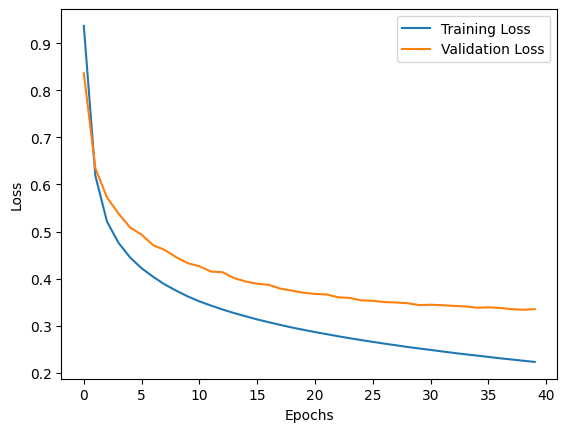

In [10]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 1 LR 0.01

In [11]:
# Define the full model
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.01)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 11s 17ms/step - loss: 0.2205 - accuracy: 0.9358 - val_loss: 0.3339 - val_accuracy: 0.9047
Epoch 2/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2179 - accuracy: 0.9365 - val_loss: 0.3353 - val_accuracy: 0.9047
Epoch 3/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2153 - accuracy: 0.9373 - val_loss: 0.3336 - val_accuracy: 0.9056
Epoch 4/10
375/375 [==============================] - 5s 13ms/step - loss: 0.2130 - accuracy: 0.9378 - val_loss: 0.3338 - val_accuracy: 0.9055
Epoch 5/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2108 - accuracy: 0.9385 - val_loss: 0.3375 - val_accuracy: 0.9047
Epoch 6/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2085 - accuracy: 0.9390 - val_loss: 0.3341 - val_accuracy: 0.9061
Epoch 7/10
375/375 [==============================] - 5s 13ms/step - loss: 0.2064 - accuracy: 0.9398 - val_loss: 0.3320 - val_accuracy: 0.906

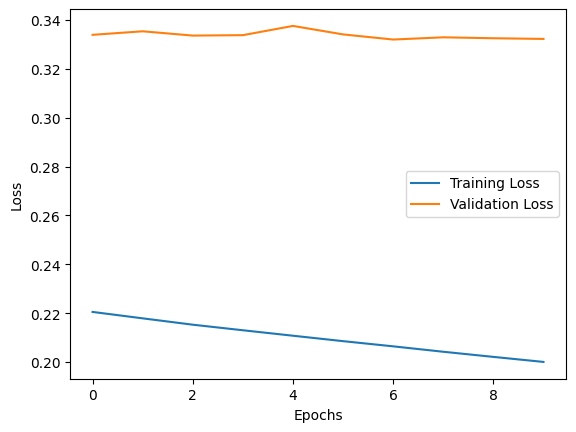

In [12]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 1 LR 0.001

Epoch 1/5
375/375 [==============================] - 9s 18ms/step - loss: 0.1983 - accuracy: 0.9420 - val_loss: 0.3320 - val_accuracy: 0.9070
Epoch 2/5
375/375 [==============================] - 6s 16ms/step - loss: 0.1959 - accuracy: 0.9428 - val_loss: 0.3337 - val_accuracy: 0.9072
Epoch 3/5
375/375 [==============================] - 5s 15ms/step - loss: 0.1941 - accuracy: 0.9432 - val_loss: 0.3325 - val_accuracy: 0.9074
Epoch 4/5
375/375 [==============================] - 5s 14ms/step - loss: 0.1921 - accuracy: 0.9437 - val_loss: 0.3349 - val_accuracy: 0.9071
Epoch 5/5
375/375 [==============================] - 5s 13ms/step - loss: 0.1901 - accuracy: 0.9443 - val_loss: 0.3351 - val_accuracy: 0.9072


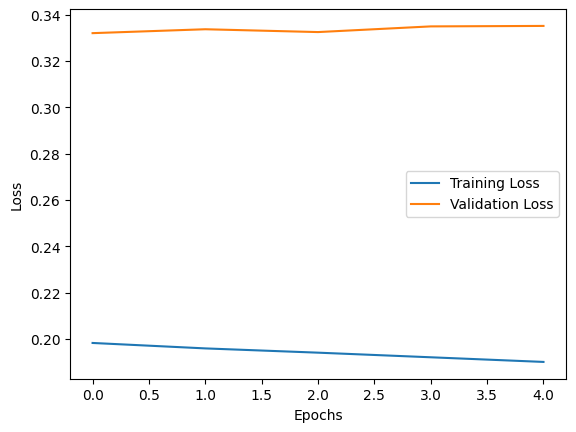

In [13]:
# Define the full model
model3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model3.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=5,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 2 LR 0.1

In [14]:
# Encoder
encoder_inputs = Input(shape=(None, num_source_tokens))
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
encoder_lstm2 = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs1)

encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_target_tokens))
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs1, initial_state=encoder_states)

decoder_dense = Dense(num_target_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


Epoch 1/30
375/375 [==============================] - 19s 34ms/step - loss: 0.9011 - accuracy: 0.7626 - val_loss: 0.9018 - val_accuracy: 0.7494
Epoch 2/30
375/375 [==============================] - 9s 23ms/step - loss: 0.7208 - accuracy: 0.7966 - val_loss: 0.7396 - val_accuracy: 0.7873
Epoch 3/30
375/375 [==============================] - 9s 25ms/step - loss: 0.6044 - accuracy: 0.8282 - val_loss: 0.6438 - val_accuracy: 0.8100
Epoch 4/30
375/375 [==============================] - 9s 24ms/step - loss: 0.5170 - accuracy: 0.8503 - val_loss: 0.5719 - val_accuracy: 0.8347
Epoch 5/30
375/375 [==============================] - 11s 29ms/step - loss: 0.4677 - accuracy: 0.8651 - val_loss: 0.5305 - val_accuracy: 0.8465
Epoch 6/30
375/375 [==============================] - 10s 28ms/step - loss: 0.4352 - accuracy: 0.8750 - val_loss: 0.5083 - val_accuracy: 0.8526
Epoch 7/30
375/375 [==============================] - 9s 24ms/step - loss: 0.4118 - accuracy: 0.8813 - val_loss: 0.4759 - val_accuracy: 0.8

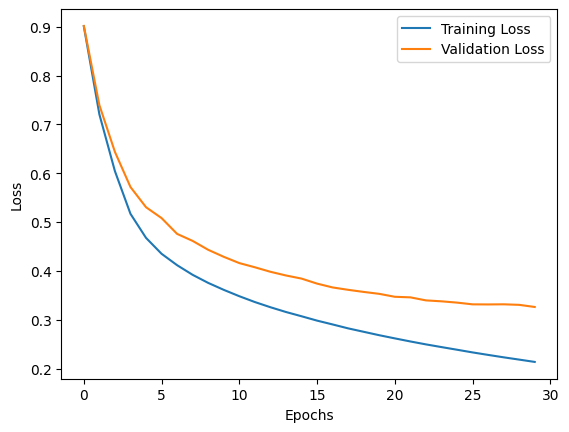

In [15]:
# Define the full model
model4 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.1)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model4.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=30,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Layer 2 LR 0.01

Epoch 1/25
375/375 [==============================] - 16s 29ms/step - loss: 0.2098 - accuracy: 0.9389 - val_loss: 0.3265 - val_accuracy: 0.9071
Epoch 2/25
375/375 [==============================] - 9s 24ms/step - loss: 0.2049 - accuracy: 0.9404 - val_loss: 0.3265 - val_accuracy: 0.9079
Epoch 3/25
375/375 [==============================] - 9s 23ms/step - loss: 0.2007 - accuracy: 0.9414 - val_loss: 0.3259 - val_accuracy: 0.9081
Epoch 4/25
375/375 [==============================] - 9s 24ms/step - loss: 0.1967 - accuracy: 0.9426 - val_loss: 0.3230 - val_accuracy: 0.9090
Epoch 5/25
375/375 [==============================] - 9s 24ms/step - loss: 0.1928 - accuracy: 0.9437 - val_loss: 0.3277 - val_accuracy: 0.9083
Epoch 6/25
375/375 [==============================] - 9s 23ms/step - loss: 0.1888 - accuracy: 0.9450 - val_loss: 0.3259 - val_accuracy: 0.9089
Epoch 7/25
375/375 [==============================] - 9s 24ms/step - loss: 0.1848 - accuracy: 0.9461 - val_loss: 0.3269 - val_accuracy: 0.909

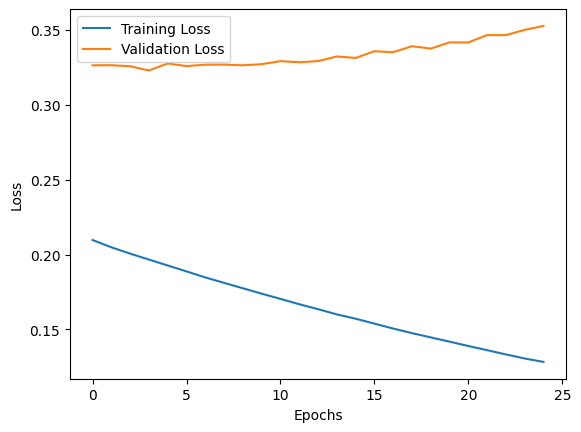

In [16]:
# Define the full model
model5 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.01)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model5.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=25,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 2 LR 0.001

Epoch 1/5
375/375 [==============================] - 16s 30ms/step - loss: 0.1258 - accuracy: 0.9628 - val_loss: 0.3522 - val_accuracy: 0.9113
Epoch 2/5
375/375 [==============================] - 9s 24ms/step - loss: 0.1229 - accuracy: 0.9636 - val_loss: 0.3575 - val_accuracy: 0.9105
Epoch 3/5
375/375 [==============================] - 9s 23ms/step - loss: 0.1203 - accuracy: 0.9644 - val_loss: 0.3590 - val_accuracy: 0.9112
Epoch 4/5
375/375 [==============================] - 9s 24ms/step - loss: 0.1180 - accuracy: 0.9652 - val_loss: 0.3628 - val_accuracy: 0.9104
Epoch 5/5
375/375 [==============================] - 9s 24ms/step - loss: 0.1156 - accuracy: 0.9658 - val_loss: 0.3620 - val_accuracy: 0.9106


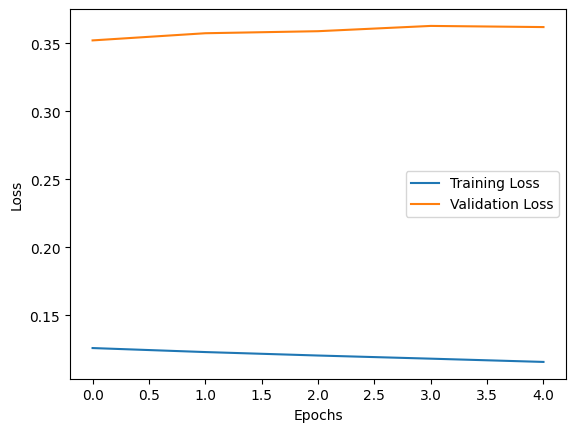

In [17]:
# Define the full model
model6 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.001)
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model6.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=5,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 3 LR 0.1

In [18]:
# Encoder
encoder_inputs = Input(shape=(None, num_source_tokens))
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)

encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_target_tokens))
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1, initial_state=encoder_states)
decoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm3(decoder_outputs2, initial_state=encoder_states)

decoder_dense = Dense(num_target_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


Epoch 1/20
375/375 [==============================] - 25s 46ms/step - loss: 0.9098 - accuracy: 0.7593 - val_loss: 0.9044 - val_accuracy: 0.7450
Epoch 2/20
375/375 [==============================] - 13s 34ms/step - loss: 0.7428 - accuracy: 0.7901 - val_loss: 0.7782 - val_accuracy: 0.7806
Epoch 3/20
375/375 [==============================] - 14s 38ms/step - loss: 0.6436 - accuracy: 0.8188 - val_loss: 0.6845 - val_accuracy: 0.8049
Epoch 4/20
375/375 [==============================] - 14s 38ms/step - loss: 0.5721 - accuracy: 0.8364 - val_loss: 0.6332 - val_accuracy: 0.8161
Epoch 5/20
375/375 [==============================] - 14s 37ms/step - loss: 0.5298 - accuracy: 0.8469 - val_loss: 0.6070 - val_accuracy: 0.8239
Epoch 6/20
375/375 [==============================] - 14s 37ms/step - loss: 0.5028 - accuracy: 0.8541 - val_loss: 0.5756 - val_accuracy: 0.8321
Epoch 7/20
375/375 [==============================] - 13s 34ms/step - loss: 0.4784 - accuracy: 0.8610 - val_loss: 0.5530 - val_accuracy:

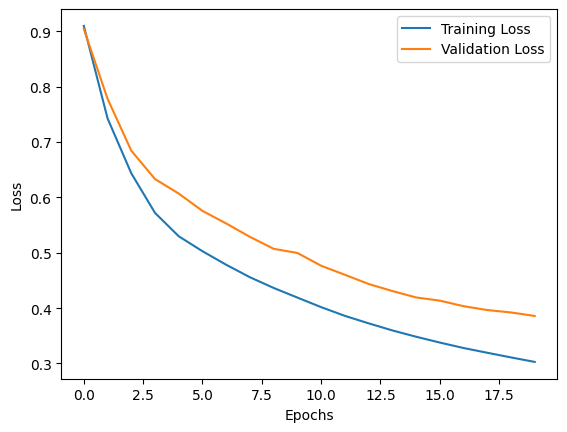

In [19]:
# Define the full model
model7 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.1)
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model7.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=20,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 3 LR 0.01

Epoch 1/30
375/375 [==============================] - 23s 44ms/step - loss: 0.2959 - accuracy: 0.9142 - val_loss: 0.3771 - val_accuracy: 0.8905
Epoch 2/30
375/375 [==============================] - 13s 35ms/step - loss: 0.2890 - accuracy: 0.9161 - val_loss: 0.3749 - val_accuracy: 0.8909
Epoch 3/30
375/375 [==============================] - 14s 38ms/step - loss: 0.2822 - accuracy: 0.9180 - val_loss: 0.3688 - val_accuracy: 0.8936
Epoch 4/30
375/375 [==============================] - 13s 34ms/step - loss: 0.2757 - accuracy: 0.9197 - val_loss: 0.3661 - val_accuracy: 0.8947
Epoch 5/30
375/375 [==============================] - 13s 34ms/step - loss: 0.2700 - accuracy: 0.9215 - val_loss: 0.3621 - val_accuracy: 0.8956
Epoch 6/30
375/375 [==============================] - 13s 34ms/step - loss: 0.2639 - accuracy: 0.9232 - val_loss: 0.3589 - val_accuracy: 0.8968
Epoch 7/30
375/375 [==============================] - 14s 37ms/step - loss: 0.2589 - accuracy: 0.9247 - val_loss: 0.3552 - val_accuracy:

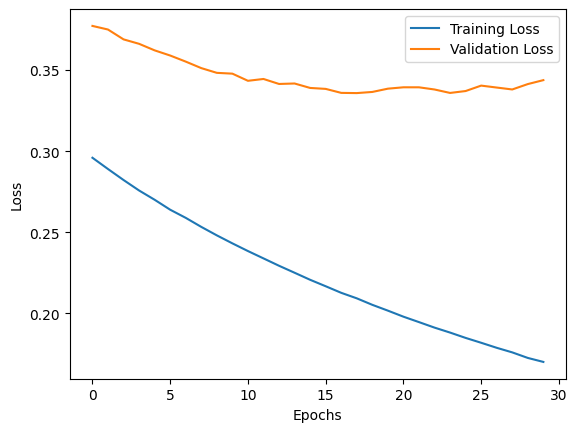

In [20]:
# Define the full model
model8 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.01)
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model8.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Layer 3 LR 0.001

Epoch 1/10
375/375 [==============================] - 24s 41ms/step - loss: 0.1681 - accuracy: 0.9508 - val_loss: 0.3445 - val_accuracy: 0.9076
Epoch 2/10
375/375 [==============================] - 13s 34ms/step - loss: 0.1646 - accuracy: 0.9518 - val_loss: 0.3421 - val_accuracy: 0.9086
Epoch 3/10
375/375 [==============================] - 13s 34ms/step - loss: 0.1615 - accuracy: 0.9527 - val_loss: 0.3474 - val_accuracy: 0.9080
Epoch 4/10
375/375 [==============================] - 13s 35ms/step - loss: 0.1593 - accuracy: 0.9533 - val_loss: 0.3479 - val_accuracy: 0.9078
Epoch 5/10
375/375 [==============================] - 13s 34ms/step - loss: 0.1563 - accuracy: 0.9541 - val_loss: 0.3484 - val_accuracy: 0.9086
Epoch 6/10
375/375 [==============================] - 13s 34ms/step - loss: 0.1542 - accuracy: 0.9547 - val_loss: 0.3481 - val_accuracy: 0.9085
Epoch 7/10
375/375 [==============================] - 13s 34ms/step - loss: 0.1517 - accuracy: 0.9555 - val_loss: 0.3496 - val_accuracy:

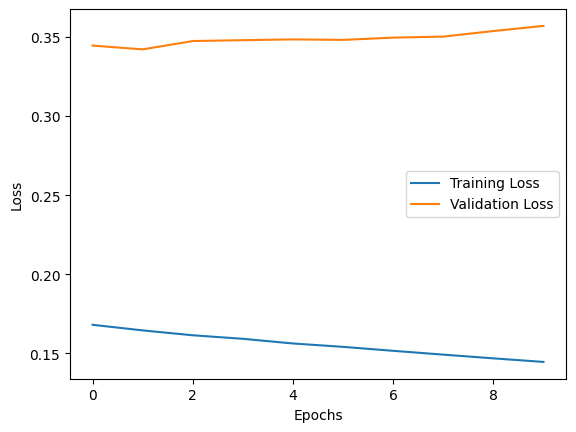

In [21]:
# Define the full model
model9 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = RMSprop(lr=0.001)
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model9.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.2)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()